In [169]:
from pyscf import gto, scf, geomopt , mp,cc
import matplotlib.pyplot as plt
from pyscf import ao2mo
import numpy as np 
import SCF as hf

In [170]:
mol = gto.M(
    atom = 'copy_CCGF/geometry/H20.xyz' ,  # Coordinates of atoms
    basis = 'cc-pvdz'                     # Basis set
)

'''
mol = gto.M(
    atom = 'H 0 0 1; F 0 1 0',  # Coordinates of atoms
    basis = 'cc-pvdz'                    # Basis set
)
'''



# Perform Hartree-Fock calcultion
mf = scf.RHF(mol)
hf_energy = mf.kernel()

# Step 3: Perform MP2 calculation
mp2_calc = mp.MP2(mf)
mp2_energy = mp2_calc.kernel()

# Step 4: Extract MP2 amplitudes (t2)
t2_amplitudes = mp2_calc.t2
print("MP2 Amplitudes (t2):", t2_amplitudes)


energy = mf.kernel()
mo_coef=mf.mo_coeff
mo_occ=mf.mo_occ
mo_energy=mf.mo_energy

def mo_ao_transform(matrix):
    tranform_matrix = mo_coef.T@matrix@mo_coef
    return tranform_matrix

# Get AO integrals
h1e_ao = mol.intor('int1e_ovlp')  # Overlap integrals
h1e_kin = mol.intor('int1e_kin')  # Kinetic energy integrals
h1e_nuc = mol.intor('int1e_nuc')  # Nuclear attraction integrals
eri_ao = mol.intor('int2e')  # Electron repulsion integrals

num_electrons = int(mol.nelectron/2-1)

#Get MO integrals 
h1e_mo=mo_ao_transform(h1e_ao)
h1e_kin_mo = mo_ao_transform(h1e_kin)
h1e_nuc_mo = mo_ao_transform(h1e_nuc)
eri_mo = mo_ao_transform(eri_ao)
nuc_rep = mol.energy_nuc()



converged SCF energy = -76.0386439565943
E(MP2) = -76.2553212318796  E_corr = -0.216677275285232
E(SCS-MP2) = -76.2540612676629  E_corr = -0.215417311068564


MP2 Amplitudes (t2): [[[[-2.28243842e-04  9.93043716e-19  6.61389728e-18 ... -1.39881030e-04
    -6.17683930e-18 -9.52851547e-04]
   [ 1.36657618e-18 -1.33056592e-04 -1.11515524e-04 ...  5.41375063e-18
    -1.68087541e-04  9.21572000e-18]
   [ 6.29901465e-18 -1.11515524e-04 -9.41709159e-05 ...  4.68847176e-18
    -1.36183555e-04  4.67035107e-17]
   ...
   [-1.39881030e-04  5.13955791e-18  5.08020163e-18 ... -1.97641616e-04
    -1.19504881e-18 -2.41018481e-04]
   [-6.14068481e-18 -1.68087541e-04 -1.36183555e-04 ... -1.19932940e-18
    -2.50949047e-04 -3.01016864e-18]
   [-9.52851547e-04  9.65316166e-18  4.54134157e-17 ... -2.41018481e-04
    -3.57472339e-18 -8.96119101e-03]]

  [[-3.82574471e-05 -2.77570622e-18 -3.78358777e-18 ... -2.31776334e-05
    -3.32541596e-18  3.21658353e-04]
   [-2.11239204e-18 -2.19363131e-04 -1.45548135e-04 ...  2.57209329e-18
    -1.22015804e-04 -2.18235639e-18]
   [-5.08099098e-18 -1.80862180e-04 -1.31596677e-04 ... -5.19799864e-19
    -7.13999450e-05 -1.592

In [141]:
# Step 3: Perform CCSD calculation
ccsd = cc.CCSD(mf)
ccsd.kernel()  # Run CCSD calculation

# Step 4: Extract correlation energy
corr_energy = ccsd.e_corr  # CCSD correlation energy
total_energy = mf.e_tot + corr_energy  # Total energy

print(f"CCSD correlation energy: {corr_energy:.6f} Hartree")
print(f"Total energy (HF + CCSD correlation): {total_energy:.6f} Hartree")

E(CCSD) = -76.26491722573711  E_corr = -0.2262732691427722
CCSD correlation energy: -0.226273 Hartree
Total energy (HF + CCSD correlation): -76.264917 Hartree


In [171]:
# Step 2: Get the Fock matrix (orbital energies) and MO coefficients
mo_coeff = mf.mo_coeff    # Molecular orbital coefficients
mo_energy = mf.mo_energy  # Orbital energies (diagonal Fock matrix)

# Step 3: Transform the two-electron integrals from AO to MO basis
# Use the pyscf ao2mo module to do the transformation
eri_ao = mol.intor('int2e')  # Two-electron integrals in AO basis
eri_mo = ao2mo.full(mf._eri, mo_coeff)  # Transform to MO basis (physicist's notation)

# Step 4: Get number of occupied and virtual orbitals
nocc =  mol.nelectron // 2   # Number of occupied orbitals (for RHF)
nmo = mo_coeff.shape[1]     # Total number of orbitals
nvir = nmo - nocc           # Number of virtual orbitals

# Step 5: Reshape the MO integrals for easier indexing
# eri_mo is in 1D, so we reshape it into a 4-index tensor
eri_mo = ao2mo.restore(1, eri_mo, mo_coeff.shape[1])  # Full 4-index tensor

# Step 6: Compute the MP2 energy
mp2_energy = 0.0

# Loop over occupied orbitals i, j and virtual orbitals a, b
for i in range(nocc):
    for j in range(nocc):
        for a in range(nocc, nvir):
            for b in range(nocc, nvir):
                # MP2 formula components
                tijab = eri_mo[i, j, a, b]*(2*eri_mo[i,j,a,b]-eri_mo[i,j,b,a])
                denominator = mo_energy[i] + mo_energy[j] - mo_energy[a] - mo_energy[b]
                
                # MP2 energy contribution
                mp2_energy += (tijab)**2 / denominator

mp2_energy *= 0.25  # Include the 1/4 factor

print("MP2 correlation energy: ", mp2_energy)

MP2 correlation energy:  -0.2658510277560579


-0.36914995396357997

In [577]:
threshold=1e-5
H =h1e_kin + h1e_nuc
E_vec,fock_matrix,init_den_new ,C0_new,fock,den = hf.scf_loop(H,num_electrons,h1e_ao,eri_ao,nuc_rep,threshold)
plt.show()

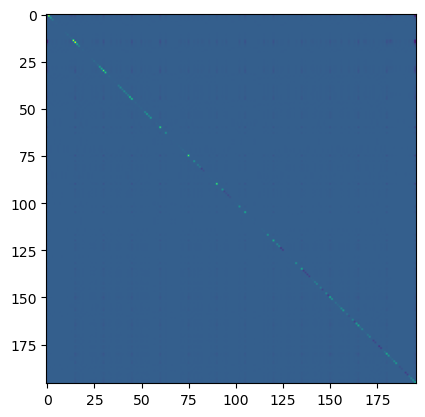

In [217]:
eri_new = eri_mo.reshape(len(eri_mo)**2,len(eri_mo)**2)
eri_new_adj = abs(eri_new - np.diag(eri_new))

degree_mat = np.zeros((len(eri_new),len(eri_new)))
for i in range(len(eri_new)):
    degree_mat[i,i] = np.sum(eri_new[i,:])
L = degree_mat-abs(eri_new)

plt.imshow(L)

In [69]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import community as community_louvain  # Louvain community detection

# Example weighted adjacency matrix (numpy array with floating point weights)
adj_matrix = np.array([
    [0, 2.5, 0, 0.4],
    [2.5, 0, 1.2, 0],
    [0, 1.2, 0, 3.7],
    [0.4, 0, 3.7, 0]
])

# Create a weighted graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)

# Generate partitions using Louvain method
partition = community_louvain.best_partition(G)

# Get unique partition groups (communities)
num_partitions = max(partition.values()) + 1

# Color map for different partitions
colors = plt.get_cmap('tab10')

# Position nodes for a better visual layout
pos = nx.spring_layout(G)

# Draw the graph with node colors based on their partition
for community in range(num_partitions):
    # Get nodes in the current partition
    nodes = [node for node in partition if partition[node] == community]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[colors(community)], node_size=700, label=f'Community {community}')

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)

# Show the graph with partitions
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'community'

In [184]:
eigenvalues, eigenvectors = np.linalg.eig(L)

In [185]:
eigenvalues

array([ 9.71255131e+00,  7.02242546e+00,  6.94396071e+00,  6.88718342e+00,
        4.96651912e+00,  4.07681781e+00,  3.24589217e+00, -2.32354021e+00,
        2.65470766e+00,  2.43877531e+00,  2.81347400e+00,  1.93019278e+00,
        2.66748459e+00,  2.47180798e+00, -1.38466626e+00,  1.96696367e+00,
       -1.15671764e+00,  1.20625370e+00, -1.31142454e+00, -1.23149511e+00,
       -1.08447580e+00,  1.11017980e+00,  6.30988883e-01,  7.45266011e-01,
        5.59774865e-01,  6.52907528e-01,  4.06756616e-01,  5.69217255e-01,
        5.52365278e-01,  3.90838917e-01,  3.80733232e-01, -4.48621457e-02,
        5.19009435e-03, -1.41666516e-02, -3.59067109e-02, -1.38966502e-02,
        1.45387085e-02,  1.10058128e-01,  5.13667535e-02,  6.91002843e-02,
        9.48888902e-02,  1.35687923e-01,  2.05552457e-01,  1.28972270e-01,
        1.35233472e-01,  1.82042372e-01,  1.61868888e-01,  1.72398617e-01,
        1.72321718e-01])

In [100]:
eri_new_adj = eri_new - np.diag(eri_new)

In [102]:
eri_new_adj[0,:]

array([ 0.        ,  0.24771652,  0.00991493, ...,  0.01458866,
       -0.15723358, -0.18024463])

In [105]:
degree_mat = np.zeros((len(eri_new),len(eri_new)))
for i in range(len(eri_new)):
    degree_mat[i,i] = np.sum(eri_new_adj[i,:])
L = degree_mat-eri_new_adj

In [109]:
np.sum(L[353,:])

3.552713678800501e-15

In [138]:
eri_new_adj[0,:]-eri_new_adj[:,0]

array([ 0.        , -0.22814659, -1.06443215, ..., -1.05431492,
       -0.72357963, -0.60901654])

In [136]:
np.sum(L[5,:])

-82.29143718166785

/Users/sarath/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


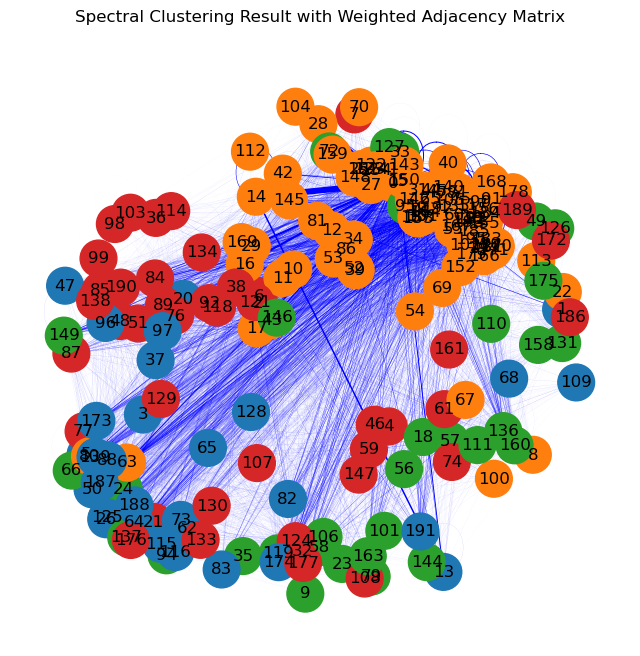

In [231]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans

def compute_laplacian(adjacency_matrix):
    """Compute the Laplacian matrix from the weighted adjacency matrix."""
    D = np.diag(np.sum(adjacency_matrix, axis=1))
    L = D - adjacency_matrix
    return L

def spectral_clustering(adjacency_matrix, n_clusters):
    """Perform spectral clustering on the given weighted adjacency matrix."""
    L = compute_laplacian(adjacency_matrix)
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    X = eigenvectors[:, :n_clusters]
    X_normalized = X / np.linalg.norm(X, axis=1, keepdims=True)
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(X_normalized)
    return labels
eri_new = eri_mo.reshape(len(eri_mo)**2,len(eri_mo)**2)
# Example: Create a weighted adjacency matrix for testing
weighted_adjacency_matrix = eri_new

# Number of clusters
n_clusters = 4

# Perform spectral clustering
labels = spectral_clustering(weighted_adjacency_matrix, n_clusters)

# Create a graph using NetworkX
G = nx.from_numpy_array(weighted_adjacency_matrix)

# Set colors based on cluster labels
color_map = [f'C{label}' for label in labels]

# Draw the graph using a spring layout
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)  # Positions for all nodes

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=700)
#nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

# Draw edges with thickness based on weights, no labels
edges = G.edges(data=True)
edge_weights = [d['weight'] for u, v, d in edges]
nx.draw_networkx_edges(G, pos, width=[weight * 1.1 for weight in edge_weights], edge_color='blue')

plt.title('Spectral Clustering Result with Weighted Adjacency Matrix')
plt.axis('off')  # Hide axes
plt.show()




In [68]:
from sklearn.cluster import KMeans
import numpy as np
import scipy.linalg as la

def build_graph_from_tensor(tensor):
    """ Build a weighted graph from a 4-dimensional tensor """
    N = len(tensor)
    comp_mat = np.zeros((N**2,N**2))
    hashmap = {}
    
    # Add nodes and weighted edges based on tensor values
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                      # Only consider non-zero interactions 
                    node1 = i*N+j
                    node2 = k*N+l
                    weight = abs(tensor[i, j, k, l])
                    comp_mat[node1,node2] = weight
                    hashmap[str(node1)+str(node2)] = np.array([i,j,k,l])
    return comp_mat,hashmap

def construct_laplacian(compatibility_matrix):
    """Construct the Laplacian matrix from the compatibility matrix."""
    # Number of nodes (should be the same as compatibility matrix dimensions)
    num_nodes = compatibility_matrix.shape[0]

    # Create the degree matrix
    degree_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        # The degree of node i is the sum of the weights of edges connected to it
        degree_matrix[i, i] = np.sum(compatibility_matrix[i, :])

    # Construct the Laplacian matrix
    laplacian_matrix = degree_matrix - compatibility_matrix

    return laplacian_matrix

def spectral_partition_k(comp_mat, k):
    # Compute Laplacian matrix
    L = construct_laplacian(comp_mat)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = la.eigh(L)
    print(eigenvalues[0])
    
    # Use the second and third eigenvectors for 3-partitioning
    #embedding = np.vstack((eigenvectors[:, 1], eigenvectors[:, 2])).T  # Create 2D embedding
    embedding = eigenvectors[:, 1:k]  # Take eigenvectors 1 to k-1
    
    # Apply k-means to partition into 3 parts
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(embedding)
    
    return labels,embedding



In [172]:
# Build a graph from the tensor
comp_mat,hashmap = build_graph_from_tensor(eri_mo)
labels,embedding =  spectral_partition_k(comp_mat, k=5)

-6.814920484130114e-17


/Users/sarath/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


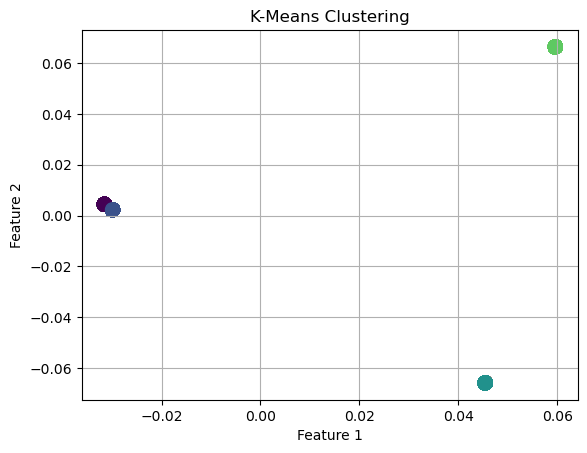

In [173]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=100, cmap='viridis', marker='o')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

In [709]:
pos = nx.spring_layout(G)  # positions for all nodes
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')  # Get edge labels if any
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Graph from Adjacency Matrix")
plt.show()

NameError: name 'nx' is not defined

In [194]:
unique_clusters = np.unique(labels)

In [710]:
pos = nx.spring_layout(G)   
# Draw the graph with node labels
plt.figure(figsize=(10, 8))
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=700, font_weight='bold')

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

NameError: name 'nx' is not defined

In [174]:
import numpy as np

def extract_submatrices_by_clusters(original_matrix, cluster_labels):
    """Generate submatrices based on specified cluster labels."""
    # Get unique cluster labels
    unique_clusters = np.unique(cluster_labels)
    submatrices = {}

    for cluster in unique_clusters:
        # Find the indices for the current cluster
        indices = np.where(cluster_labels == cluster)[0]

        # Create submatrix for the current cluster
        submatrix = original_matrix[np.ix_(indices, indices)]
        submatrices[cluster] = submatrix

    return submatrices

# Example usage
# Assume original_matrix is obtained from previous steps
original_matrix = np.array([[1, 2, 0, 0],
                             [2, 3, 1, 0],
                             [0, 1, 4, 5],
                             [0, 0, 5, 6]])

# Example cluster labels for a graph with 4 nodes
cluster_labels = np.array([0, 0, 1, 1])  # Nodes 0 and 1 in cluster 0, nodes 2 and 3 in cluster 1

# Extract submatrices based on the cluster labels
submatrices = extract_submatrices_by_clusters(comp_mat, labels)

# Print the resulting submatrices
for cluster, submatrix in submatrices.items():
    print(f"Submatrix for cluster {cluster}:")
    print(submatrix)

Submatrix for cluster 0:
[[0.01917767 0.01029788 0.00872488 ... 0.00105274 0.01380845 0.00979895]
 [0.01029788 0.00553216 0.00469421 ... 0.00056999 0.00740914 0.00530296]
 [0.00872488 0.00469421 0.0040128  ... 0.00048738 0.00623693 0.00461691]
 ...
 [0.00105274 0.00056999 0.00048738 ... 0.00055517 0.00126298 0.00083332]
 [0.01380845 0.00740914 0.00623693 ... 0.00126298 0.01626568 0.00710542]
 [0.00979895 0.00530296 0.00461691 ... 0.00083332 0.00710542 0.0144325 ]]
Submatrix for cluster 1:
[[4.73988384e+00 4.29826620e-01 1.37027403e-01 ... 1.88400587e-02
  4.48800743e-02 4.14778182e+00]
 [4.29826620e-01 6.32176356e-02 1.68151794e-02 ... 2.10113927e-03
  3.97276083e-03 3.68882477e-01]
 [1.37027403e-01 1.68151794e-02 2.95637647e-02 ... 1.98264572e-03
  1.09386419e-02 1.15896562e-01]
 ...
 [1.88400587e-02 2.10113927e-03 1.98264572e-03 ... 7.92214300e-03
  9.11526594e-04 1.75541734e-02]
 [4.48800743e-02 3.97276083e-03 1.09386419e-02 ... 9.11526594e-04
  1.27302687e-02 4.06497653e-02]
 [4.14

In [175]:
unique_clusters = np.unique(labels)
for i in range(len(unique_clusters)):
    indices = np.where(labels == unique_clusters[i])[0]
    print(unique_clusters[i])
    print(indices)


0
[  2   6   7  11  16  17  23  27  31  32  36  41  42  48  50  51  53  55
  58  60  62  65  68  71  72  74  77  81  82  86  91  92  98 113 120 127
 131 132 136 141 142 148 150 151 153 155 158 160 162 165 168 171 172 174
 175 176 178 180 183 185 187 190 193 196 197 199 202 206 207 211 216 217
 223 238 245 252 256 257 261 266 267 273 275 276 278 280 283 285 287 290
 293 296 297 299 302 306 307 311 316 317 323 329 334 339 344 363 370 377
 381 382 386 391 392 398 400 401 403 405 408 410 412 415 418 421 422 424
 425 426 428 430 433 435 437 440 443 446 447 449 452 456 457 461 466 467
 473 488 495 504 509 514 519 527 531 532 536 541 542 548 552 556 557 561
 566 567 573 575 576 578 580 583 585 587 590 593 596 597 599 602 606 607
 611 616 617 623]
1
[  0   1   3   5   8  10  12  15  18  21  22  24  25  26  28  30  33  35
  37  40  43  46  47  49  52  56  57  61  66  67  73  75  76  78  80  83
  85  87  90  93  96  97  99 104 109 114 119 125 126 128 130 133 135 137
 140 143 146 147 149 152 156 

(array([25188., 14921., 22401., 14044., 15973., 15990., 15801., 19506.,
        11711., 25941.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

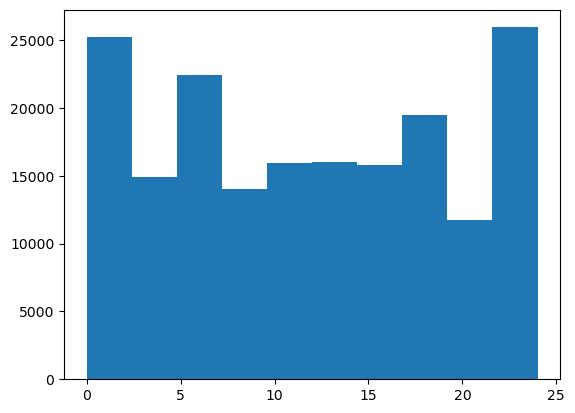

In [163]:
indices = np.where(labels == unique_clusters[1])[0]
sup_arr = []
for num in indices:
    for num2 in indices:
        vec = hashmap[str(num)+str(num2)]
        sup_arr.append(vec)
sup_arr = np.array(sup_arr)
plt.hist(sup_arr.flatten())

In [176]:
for i in range(len(submatrices)):
    print('Trace of the submatrix --> ',np.sum(submatrices[i]),'    relative dim --> ',len(submatrices[i])**2/len(eri_mo)**4*100,'%')

Trace of the submatrix -->  295.1583469088019     relative dim -->  8.667136000000001 %
Trace of the submatrix -->  1011.9402680171705     relative dim -->  11.614464 %
Trace of the submatrix -->  109.0529342579692     relative dim -->  3.9362559999999998 %
Trace of the submatrix -->  39.273680698700936     relative dim -->  2.715904 %
Trace of the submatrix -->  8.220550515852195e-05     relative dim -->  0.000256 %


In [412]:
t2_amplitudes[0]

array([[[-3.06705762e-04,  1.26801736e-17, -1.17833224e-19,
         -1.99487138e-04,  1.63785719e-17,  3.34584784e-04,
         -7.62264236e-17,  5.70999104e-04, -9.65955697e-04],
        [ 1.24281399e-17, -2.28254019e-04, -8.89615890e-19,
          1.01801059e-17,  2.41130778e-04, -8.15741367e-17,
         -4.01542889e-04, -5.53835367e-17,  8.31804712e-17],
        [-1.17833224e-19, -8.89615890e-19, -8.22114346e-04,
         -2.83395971e-19, -2.12163717e-18,  1.29527472e-19,
         -1.14778543e-18, -8.38210071e-20,  1.73749185e-19],
        [-1.99487138e-04,  1.00789964e-17, -2.83395971e-19,
         -8.15607373e-04,  8.87375545e-18,  2.31988136e-04,
         -2.74515750e-17, -2.00474217e-04,  4.25403678e-04],
        [ 1.63161257e-17,  2.41130778e-04, -2.12163717e-18,
          8.89445681e-18, -2.55916433e-04,  5.38770274e-17,
          4.25355098e-04,  2.89309655e-18,  5.56093141e-18],
        [ 3.34584784e-04, -8.15351850e-17,  1.29527472e-19,
          2.31988136e-04,  5.385621

196

In [392]:
len(submatrices[0])

188

In [554]:
sum = 0
sum_len = 0
for i in range(len(submatrices)):
    sum += np.sum(submatrices[i])
    sum_len+= len(submatrices[i])**2/len(eri_mo)**4*100
#sum = sum/np.sum(eri_mo)*100
sum,sum_len

(132.84938826823745, 90.0926697209496)

In [501]:
len(mo_energy)

14

In [529]:
len(sup_arr)

1

In [92]:

# Loop over occupied orbitals i, j and virtual orbitals a, b
for elem in sup_arr:
    if (elem[0] and elem[1] < nocc):
        if (elem[2] and elem[3] > nvir):
            i = int(elem[0])
            j = int(elem[1])
            a = int(elem[2])
            b = int(elem[3])
            print(i,j,a,b)
        # MP2 formula components
            tijab = eri_mo[i, j, a, b]*(2*eri_mo[i,j,a,b]-eri_mo[i,j,b,a])
            denominator = mo_energy[i] + mo_energy[j] - mo_energy[a] - mo_energy[b]

            # MP2 energy contribution
            mp2_energy += (tijab)**2 / denominator

            mp2_energy *= 0.25  # Include the 1/4 factor

print("MP2 correlation energy: ", mp2_energy)

MP2 correlation energy:  0.0


MP2 correlation energy:  -0.017378068039470222 8.667136000000001
MP2 correlation energy:  -6.205469971257383 11.614464
MP2 correlation energy:  -0.01614881198801356 3.9362559999999998
MP2 correlation energy:  -0.00031446147686596456 2.715904
MP2 correlation energy:  0.0 0.000256


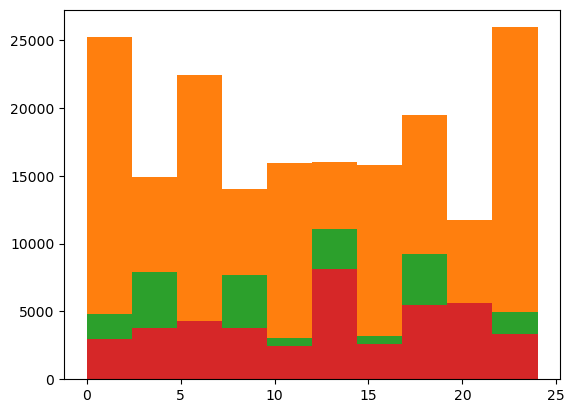

In [185]:
# Assuming sup_arr is defined and has the correct structure (a list of tuples or lists)
for i in range(5):
    mp = []
    indices = np.where(labels == unique_clusters[i])[0]
    sup_arr = []
    for num in indices:
        for num2 in indices:
            vec = hashmap[str(num)+str(num2)]
            sup_arr.append(vec)
    sup_arr = np.array(sup_arr)
    plt.hist(sup_arr.flatten())
    mp2_energy = 0.0  # Initialize MP2 energy

    # Loop over indices from sup_arr
    for elem in sup_arr:
        i = int(elem[0])
        j = int(elem[1])
        a = int(elem[2])
        b = int(elem[3])

        # Ensure i, j are occupied and a, b are virtual
        if i < nocc and j < nocc and a >= nocc and b >= nocc:
            

            # MP2 formula components with antisymmetrization
            tijab = eri_mo[i, j, a, b]*(2*eri_mo[i, j, a, b] - eri_mo[i, a, j, b])
            denominator = mo_energy[i] + mo_energy[j] - mo_energy[a] - mo_energy[b]

            # MP2 energy contribution
            mp2_energy = mp2_energy +  (tijab) / denominator

    # Apply the final scaling factor after the loop

    mp2_energy *= 1 # Include the 1/4 factor
    mp.append(mp2_energy)
    sum_len = len(sup_arr)/len(eri_mo)**4*100
    print("MP2 correlation energy: ", mp2_energy,sum_len)


-0.2859794915914304

In [700]:
-0.23777736312304343-0.0025098090583225816

-0.240287172181366

In [865]:
len(submatrices[4])**2

147456

In [869]:
len(submatrices[3])**2/len(eri_mo)**4

0.004200960219478738

In [166]:
sup_arr[10]

array([ 0,  0,  0, 22])